In [ ]:
!pip install imbalanced-learn

In [ ]:
#importing SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


In [ ]:
#changing a file to dataset
import io
df = pd.read_csv(io.BytesIO(uploaded['bank-additional-full.csv']), sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Quick glimpse on data

In [ ]:
print('the provided bank data has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

the provided bank data has 41188 rows and 21 columns


In [ ]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [ ]:
#checking null values in data
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Glad there are no missing values in our dataset

In [ ]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [ ]:
#Checking for the unique values
unique_values = pd.DataFrame(columns=['Unique Values'])
for x in list(df.columns.values):
    unique_values.loc[x] = [df[x].nunique()]
unique_values

,Unique Values
age,78
job,12
marital,4
education,8
default,3
housing,3
loan,3
contact,2
month,10
day_of_week,5


Predict variable (desired target):
y — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [ ]:
df['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

Let us group “basic.4y”, “basic.9y” and “basic.6y” together and call them “basic”.

In [ ]:
df['education']=np.where(df['education'] =='basic.9y', 'Basic', df['education'])
df['education']=np.where(df['education'] =='basic.6y', 'Basic', df['education'])
df['education']=np.where(df['education'] =='basic.4y', 'Basic', df['education'])

In [ ]:
#after groupby the column become
df['education'].unique()

array(['Basic', 'high.school', 'professional.course', 'unknown',
       'university.degree', 'illiterate'], dtype=object)

Explore the target variable

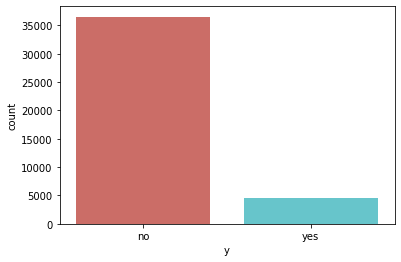

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.countplot(x = 'y', data = df, palette = 'hls' )
plt.show()
plt.savefig('count_plot')

Let us see the percentage ratio of each value in our target variable

In [ ]:
#percentage calculation
no_subs = len(df[df['y']=='no'])
yes_sub = len(df[df['y']=='yes'])
pct_of_no_sub = no_subs/(no_subs+yes_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = yes_sub/(no_subs+yes_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.73458288821988
percentage of subscription 11.265417111780131


Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 89:11. Before we go ahead to balance the classes, let’s do some more exploration and preprocessing.

In [ ]:
df.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
yes,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


**Observations:**
 

* The average age of customers who bought the term deposit is higher than that of the customers who didn’t.

* The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.   

*  Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit. 



**EDA**
Here we will do some few visualization (bivariate) to see which columns may be a good predictor of our target variable

Further EDA can be found here(https://dub01.online.tableau.com/#/site/multipleviews/views/Bank_EDAStory/Story1)

In [ ]:
def plot_data(data,x, y):
  '''
  a function to visualize some columns against others
  3parameters: dataframe, a column to be on x axis and another column on y axis
  returns nothing 
  '''
  pd.crosstab(data[x],data[y]).plot(kind='bar')
  plt.title('Purchase Frequency for {}'.format(x))
  plt.xlabel(x)
  plt.ylabel('Frequency of Purchase')
  # plt.savefig('pur_fre_{}_bar'.format(data[x]))
  plt.show()

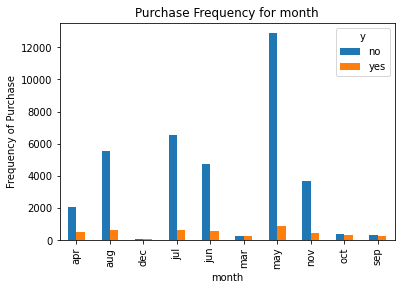

In [ ]:
#month plotting
plot_data(df, 'month','y')


Month  seem to be a good predictor for the target variable

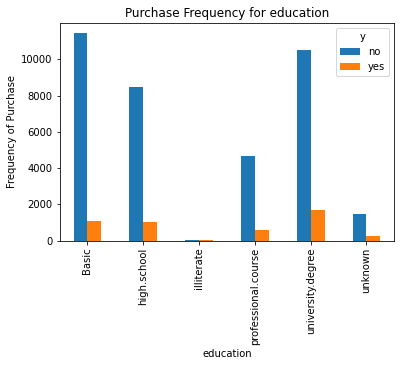

In [ ]:
#education plotting
plot_data(df, 'education','y')


Education seems a good predictor of the outcome variable.

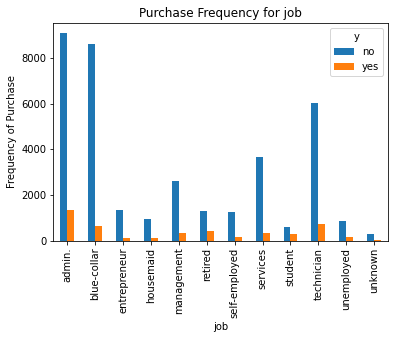

In [ ]:
#job plotting against purchase
plot_data(df,'job','y')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

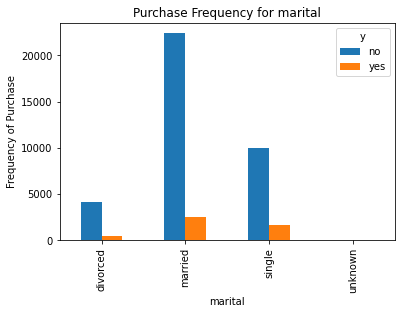

In [ ]:
#plotting marital status against purchase
plot_data(df, 'marital', 'y')


The marital status does not seem a strong predictor for the outcome variable.

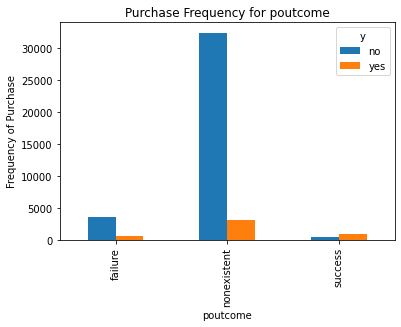

In [ ]:
#plotting previous outcome with the target
plot_data(df, 'poutcome', 'y')

the previous otcome seems to be a good predictor for the target variable

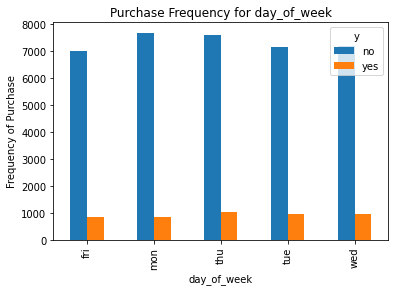

In [ ]:
#plotting last call on days of the week against target
plot_data(df, 'day_of_week', 'y')

Day of week may not be a good predictor of the outcome

# Preprocessing

**Feature Engineering**
This will be done by aggregating some columns over age

In [ ]:
#Finding the age distribution on marital status
df['maritalMeanAge'] = df.groupby ('marital')['age'].transform('mean')

In [ ]:
#age distribution on client jobs
df['jobMeanAge'] = df.groupby ('job')['age'].transform('mean')

In [ ]:
#age Distribution on client education
df['educationMeanAge'] = df.groupby ('education')['age'].transform('mean')

In [ ]:
#age distribution on client who took loan
df['loanMeanAge'] = df.groupby ('loan')['age'].transform('mean')

In [ ]:
#Age distribution on previous outcome
df['poutcomeMeanAge'] = df.groupby ('poutcome')['age'].transform('mean')

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,maritalMeanAge,jobMeanAge,educationMeanAge,loanMeanAge,poutcomeMeanAge
0,56,housemaid,married,Basic,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,42.307165,45.500000,42.163910,40.058822,39.95619
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,42.307165,37.926430,37.998213,40.058822,39.95619
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,42.307165,37.926430,37.998213,40.058822,39.95619
3,40,admin.,married,Basic,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,42.307165,38.187296,42.163910,40.058822,39.95619
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,42.307165,37.926430,37.998213,39.846671,39.95619


**One Hot Encoding**
Changing categorical data into numerical by using one hot encoder, this is preferable because it is used to encode both nominal and ordinal variables.

In [ ]:
from sklearn.base import TransformerMixin

class DataFrameEncoder(TransformerMixin):

    def __init__(self):
        """Encode the data.

        Columns of data type object are appended in the list. After 
        appending Each Column of type object are taken dummies and 
        successively removed and two Dataframes are concated again.

        """
    def fit(self, X, y=None):
        self.object_col = []
        for col in X.columns:
            if(X[col].dtype == np.dtype('O')):
                self.object_col.append(col)
        return self

    def transform(self, X, y=None):
        dummy_df = pd.get_dummies(X[self.object_col],drop_first=True)
        X = X.drop(X[self.object_col],axis=1)
        X = pd.concat([dummy_df,X],axis=1)
        return X


we will first drop the target variable for encoding it using label encoder(integer incoder)

In [ ]:
df1 = df.drop(columns =['y'])
enc = DataFrameEncoder()
enc.fit(df1)
data = enc.transform(df1)
print('new data has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

new data has 41188 rows and 58 columns


In [ ]:
#dealing with target
target = df['y'].values
target

array(['no', 'no', 'no', ..., 'no', 'yes', 'no'], dtype=object)

Interestingly, while we never use integer-encoding for nominal descriptive features, we need to do just that for a nominal target feature!

As the LabelEncoder labels in an alphabetical order. That is, "n" is labeled as 0 whereas "y" as labeled as 1. In general the positive class need to be 1 and the negative one need to be 0 for our case the label encoder will d it well as we can not be sure of it every day we will use the numpy replace method and define labels manually.

In [ ]:
# first convert "target" to a Series so that we can use the replace function
target_encoded_replace = pd.Series(target).replace({'no': 0, 'yes': 1}).values

np.unique(target_encoded_replace, return_counts = True)

(array([0, 1]), array([36548,  4640]))

In [ ]:
#changing target numpy array to dataframe
df_target = pd.DataFrame(target_encoded_replace, columns = ['y'])

**Scaling Data**

This is done for avoiding the model to produce bias prediction, Min max scaler will be used over standard scaler because the later use mean and standard deviation of data and some of our data are labels.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# data= scaler.fit_transform(data)
# data_scaled = pd.DataFrame(data)
# data_scaled.head()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
# data_scaled.head()

In [ ]:
data_scaled = data_scaled.drop(columns=['duration'])

# Class Balancing

For balancing the class We will use SMOTE technique which generates synthetic data for the minority class.

In [ ]:
#spliting data into test and train set before balancing
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_scaled, df_target, test_size=0.1, 
                                                                    random_state=21)
X_train, y_train = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('xtrain shape:', X_train.shape)
print('xtest shape:', X_test.shape)
print('ytrain shape:', y_train.shape)
print('ytest shape:', y_test.shape)

xtrain shape: (65784, 55)
xtest shape: (4119, 55)
ytrain shape: (65784,)
ytest shape: (4119, 1)


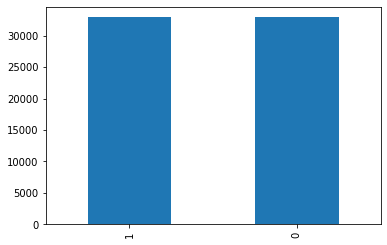

In [ ]:
# observe that data has been balanced
pd.Series(y_train).value_counts().plot.bar()

# Dimensionality Reduction

Our data classes are now balanced ready for being given to the model.

In [ ]:
from sklearn.decomposition import PCA
#make a pca object
pca = PCA(n_components=15)
pca_result_train = pca.fit_transform(X_train)
pca_result_test= pca.fit_transform(X_test)

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

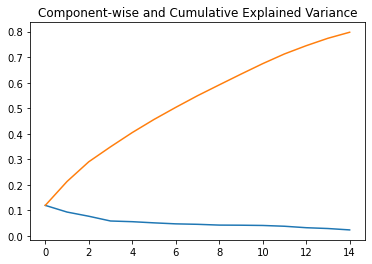

In [ ]:
plt.plot(range(15), pca.explained_variance_ratio_)
plt.plot(range(15), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")


In the above graph, the blue line represents component-wise explained variance while the orange line represents the cumulative explained variance. We are able to explain around 80% variance in the dataset using just 15 components.

In [ ]:
#converting pca result and target train value to dataframe
x_train = pd.DataFrame(pca_result_train)
x_test = pd.DataFrame(pca_result_test)
y_train = pd.DataFrame(y_train)
y_train.columns = ['y']
y_train.shape

(65784, 1)

# modeling

In this part we defined a class(TrainModels) which has four function where each one train and predict values for a model respectively. we will choose the top 3 models depending on their perfomance.
tho models trained are:

1. logistic regression
2. random forest regressor
3. multilayer perceptron
4.xgboost

Let's go ahead and find the top 3



In [ ]:
class TrainModels():
  '''
      each function in this class; 
      Receive data to train(features and target) as parameters
      creates a model object and fit the model with the data
      returns a model fitted
  '''

  def __init(self):
      
      return self
  #a function to train a logistic regression
  def train_logistic(self, X_train, X_test, y_train, y_test):

      log_reg = LogisticRegression()
      log_reg.fit(X_train, y_train)
      ypreds = log_reg.predict(X_test)
      return log_reg, ypreds
  
  def random_forest(self, X_train,X_test, y_train, y_test):
      clf = RandomForestClassifier(n_estimators=100)
      #Train the model using the training sets y_pred=clf.predict(X_test)
      clf.fit(X_train,y_train)
      ypreds2 = clf.predict(X_test)
      return clf, ypreds2
  
  def train_MLP(self, X_train, X_test, y_train, y_test):
      clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                          hidden_layer_sizes=(15,), random_state=1)
      clf_mlp.fit(X_train, y_train)
      ypreds3 = clf_mlp.predict(X_test)
      return clf_mlp, ypreds3
  
  def xgb_classifier(self, X_train, X_test, y_train, y_test):
      #Create XGB Classifier
      model = XGBClassifier()
      #Train the model using the training sets
      model.fit(X_train,y_train)
      y_pred =model.predict(x_test)
      return model,y_pred



In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#creating a train model class object
train = TrainModels()
#train and predict using logistic regression
log_reg, ypreds = train.train_logistic(x_train, x_test, y_train, y_test)
# ypreds = log_reg.predict(x_test)
#ypreds

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False), array([1, 0, 0, ..., 1, 1, 0]))

In [ ]:
#training and predicting using random forest classifier
clf, ypreds2 = train.random_forest(x_train, x_test, y_train, y_test)
# ypreds2 = clf.predict(x_test)
ypreds2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
#training and predicting using multilayer percepetron
clf_mlp, ypreds3 = train.train_MLP(x_train, x_test, y_train, y_test)
# ypreds3 = clf_mlp.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
#training and predicting using xgboost classifier
model, y_pred = train.xgb_classifier(x_train, x_test, y_train, y_test)
# y_pred =model.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Accuracy measure**

In [ ]:
#logistic regression accuracy
print('Accuracy of logistic regression on test set: {:.2f}'.format(log_reg.score(x_test, y_test)))

Accuracy of logistic regression on test set: 0.54


In [ ]:
#random forest regressor accuracy
print('Accuracy of random forest classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))

Accuracy ofrandom forest classifier on test set: 0.78


In [ ]:
#MLP accuracy
print('Accuracy of multilayer perceptron on test set: {:.2f}'.format(clf_mlp.score(x_test, y_test)))

Accuracy of multilayer perceptron on test set: 0.44


In [ ]:
#xg boost accuracy
print('Accuracy of xgboost on test set: {:.2f}'.format(model.score(x_test, y_test)))

Accuracy of xgboost on test set: 0.62


**Observation**
 we can see that our top three models are:
1. Random forest classifier
2. XgBoost classifier
3. logistic regression



#  k_fold Cross Validation

In [ ]:
#5-fold cross validation
kfold = model_selection.KFold(n_splits=5, random_state=0)
#cross validating logistic regression
results_kfold = model_selection.cross_val_score(log_reg, x_train, y_train, cv=kfold)
print("Logistic regresssion Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Logistic regresssion Accuracy: 63.31%


In [ ]:
#cross validating random forest regressore
results2_kfold = model_selection.cross_val_score(clf, x_train, y_train, cv=kfold)
print("Random forest prediction Accuracy: %.2f%%" % (results2_kfold.mean()*100.0))

Random forest prediction Accuracy: 85.88%


In [ ]:
#cross validating MLP
results3_kfold = model_selection.cross_val_score(clf_mlp, x_train, y_train, cv=kfold)
print("Multilayer perceptron prediction Accuracy: %.2f%%" % (results3_kfold.mean()*100.0))

Multilayer perceptron prediction Accuracy: 70.80%


In [ ]:
#cross validating XGBoost
results4_kfold = model_selection.cross_val_score(model, x_train, y_train, cv=kfold)
print("XGBoost prediction Accuracy: %.2f%%" % (results3_kfold.mean()*100.0))

XGBoost prediction Accuracy: 70.80%


from the k_fold the top models are:

1. Random forest Regressor
2. MLP and XGboost 
3. logistic regression



# Evaluation Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r_sq))
    print('MAE Score: {}'.format(mae))

In [ ]:
#calculating logistic legression perfomance
calculate_metrics(y_test, ypreds)

RMSE Score: 0.6788162153605828
R2_Squared: -3.6184986601509515
MAE Score: 0.46079145423646517


In [ ]:
#calculating random forest regressor perfomance
calculate_metrics(y_test, ypreds2)

RMSE Score: 0.48024837791645003
R2_Squared: -1.3116826802652284
MAE Score: 0.2306385044913814


In [ ]:
#calculating MLP perfomance
calculate_metrics(y_test, ypreds3)

RMSE Score: 0.7655485476318649
R2_Squared: -4.8741073580634335
MAE Score: 0.5860645787812576


In [ ]:
#calculating XGBoost perfomance
calculate_metrics(y_test, y_pred)

RMSE Score: 0.6106603353392059
R2_Squared: -2.7376258914604117
MAE Score: 0.3729060451565914


it is clearly seen that the perfomance metrics for the model we selected are consective as their cross validation perfomance